In [3]:


import numpy as np
import pandas as pd
import seaborn as sns

""" import plotly.io as pio
import plotly.express as px
import plotly. graph_objects as go """
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.cluster import KMeans
#from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, normalize

import sys
import os
sys.path.insert(0,os.path.abspath('../scripts'))

import functions as fn
import importlib
importlib.reload(fn)



<module 'functions' from 'c:\\Users\\HP\\Desktop\\TenX\\user-overview-analysis\\scripts\\functions.py'>

In [4]:
cleaned_data = pd.read_csv('../data/clean_telecom_data.csv')
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Bearer Id                       148506 non-null  float64
 1   Start                           148506 non-null  object 
 2   Start ms                        148506 non-null  float64
 3   End                             148506 non-null  object 
 4   End ms                          148506 non-null  float64
 5   Dur. (ms)                       148506 non-null  float64
 6   IMSI                            148506 non-null  float64
 7   MSISDN/Number                   148506 non-null  float64
 8   IMEI                            148506 non-null  float64
 9   Last Location Name              148506 non-null  object 
 10  Avg RTT DL (ms)                 148506 non-null  float64
 11  Avg RTT UL (ms)                 148506 non-null  float64
 12  Avg Bearer TP DL

In [5]:
user_engagement_df = cleaned_data[['MSISDN/Number', 'Bearer Id', 'Dur. (ms)', 'Total DL (Bytes)']].copy().rename(columns={
    'Bearer Id': 'Session_Frequency', 'MSISDN/Number':'Customer_Id', 'Dur. (ms)': 'Duration', 'Total DL (Bytes)': 'Total_Data_Volume'})
print(user_engagement_df.columns)

Index(['Customer_Id', 'Session_Frequency', 'Duration', 'Total_Data_Volume'], dtype='object')


In [6]:
#Aggregating Session_Frequency,Duration and Total_Data_Volume per Customer_Id and Displaying top 10 
user_engagement = user_engagement_df.groupby('Customer_Id').agg({'Session_Frequency': 'count', 'Duration': 'sum', 'Total_Data_Volume': 'sum'})
user_engagement.head(10)

,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,
3.360100e+10,1,116720.00,8.426375e+08
3.360100e+10,1,181230.00,1.207552e+08
3.360100e+10,1,134969.00,5.566597e+08
3.360101e+10,1,49878.00,4.019932e+08
3.360101e+10,2,37104.00,1.363130e+09
3.360101e+10,2,253983.00,5.552080e+08
3.360101e+10,2,128360.00,5.530412e+08
3.360101e+10,1,86399.00,2.940851e+08
3.360101e+10,2,400808.75,8.965602e+08


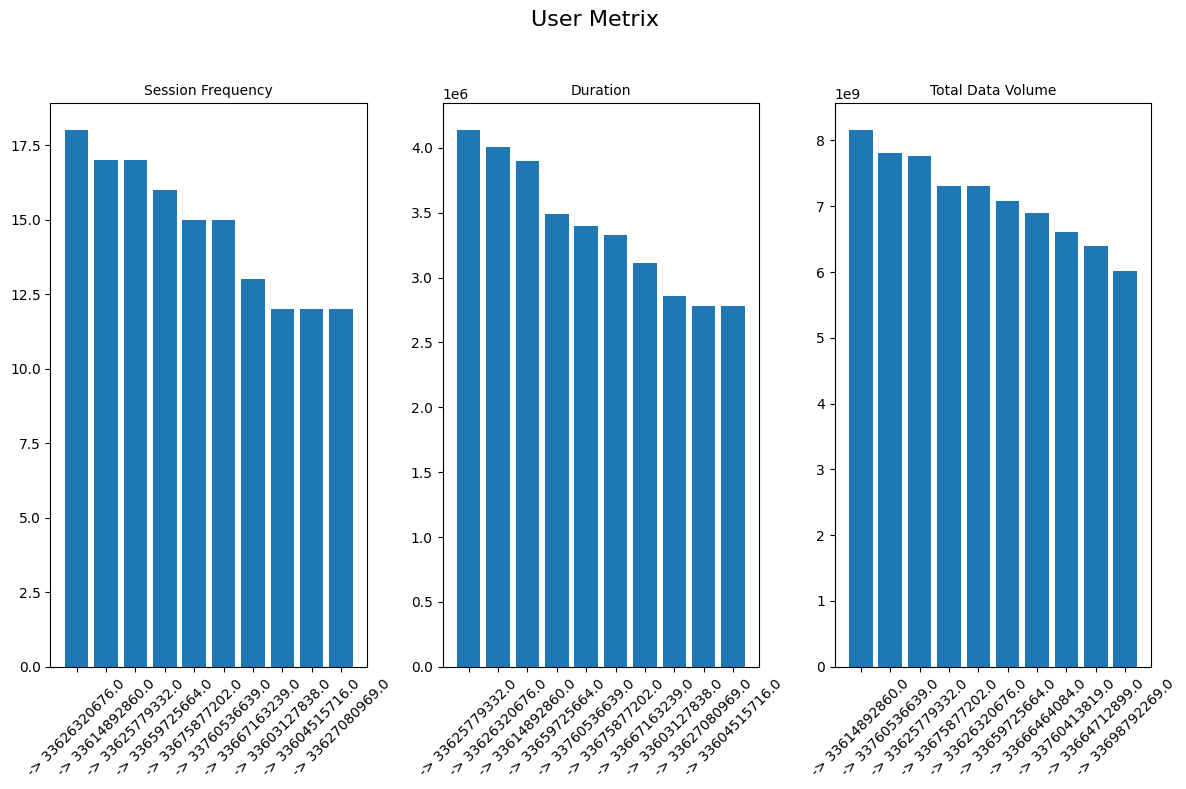

In [7]:
#Displaying top 10  customer engagement
sessions = user_engagement.nlargest(10, "Session_Frequency")['Session_Frequency']
duration = user_engagement.nlargest(10, "Duration")['Duration']
total_data_volume = user_engagement.nlargest(10, "Total_Data_Volume")['Total_Data_Volume']

fn.mult_hist([sessions, duration, total_data_volume], 1,
          3, "User Metrix", ['Session Frequency', 'Duration', 'Total Data Volume'])

<Axes: >

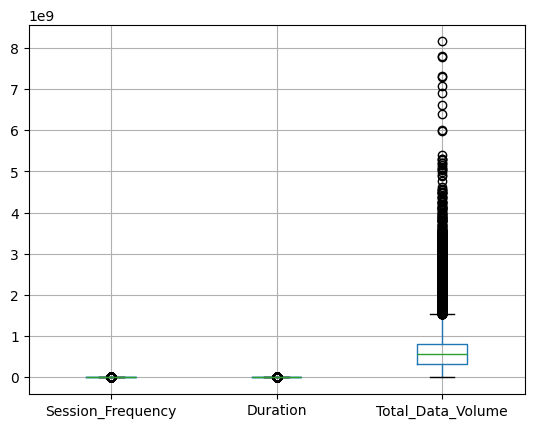

In [8]:
# Check for outliers 

user_engagement.boxplot()

In [9]:
#Normalize the Engagement Metrics
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_engagement)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.489228,-0.174274,0.448341
1,-0.489228,0.319105,-1.104150
2,-0.489228,-0.034704,-0.166687
3,-0.489228,-0.685489,-0.499315
4,0.749944,-0.783185,1.567721


In [10]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.713063,-0.254009,0.653468
1,-0.391656,0.255463,-0.883937
2,-0.944440,-0.066994,-0.321785
3,-0.499693,-0.700151,-0.509996
4,0.393427,-0.410865,0.822439


In [11]:
# K=3 to classify customers 
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

array([1, 2, 2, ..., 2, 2, 2])

In [12]:
user_engagement.insert(0, 'Cluster', kmeans.labels_)
user_engagement.head(5)

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
3.360100e+10,1,1,116720.0,8.426375e+08
3.360100e+10,2,1,181230.0,1.207552e+08
3.360100e+10,2,1,134969.0,5.566597e+08
3.360101e+10,2,1,49878.0,4.019932e+08
3.360101e+10,0,2,37104.0,1.363130e+09


In [13]:
user_engagement['Cluster'].value_counts()
user_engagement.head()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
3.360100e+10,1,1,116720.0,8.426375e+08
3.360100e+10,2,1,181230.0,1.207552e+08
3.360100e+10,2,1,134969.0,5.566597e+08
3.360101e+10,2,1,49878.0,4.019932e+08
3.360101e+10,0,2,37104.0,1.363130e+09


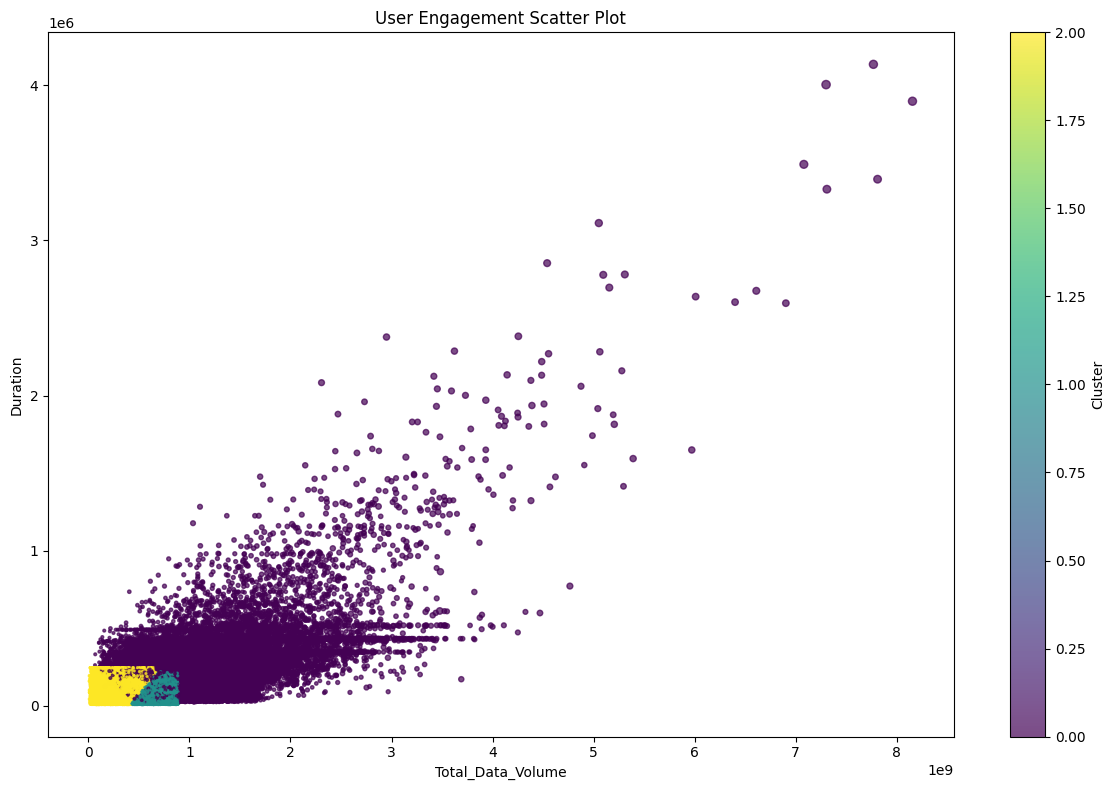

In [14]:
fn.plot_scatter_pandas(user_engagement, 'Total_Data_Volume', 'Duration', 'Cluster', 'Session_Frequency')

In [15]:
#Compute the minimum, maximum, average & total non-normalized metrics for each cluster. 

cluster1 = user_engagement[user_engagement["Cluster"]==0]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,29699.0,29699.000000,2.969900e+04,2.969900e+04
mean,0.0,2.397454,2.463642e+05,1.111078e+09
std,0.0,0.960575,1.922346e+05,5.548327e+08
min,0.0,1.000000,1.823500e+04,6.527075e+07
25%,0.0,2.000000,1.387585e+05,7.512277e+08
50%,0.0,2.000000,2.104120e+05,1.011282e+09
75%,0.0,3.000000,3.124405e+05,1.358300e+09
max,0.0,18.000000,4.136008e+06,8.156743e+09


In [16]:
cluster1 = user_engagement[user_engagement["Cluster"]==1]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,30695.0,30695.0,30695.000000,3.069500e+04
mean,1.0,1.0,83096.784134,6.946011e+08
std,0.0,0.0,47938.312575,1.105117e+08
min,1.0,1.0,7142.000000,4.240814e+08
25%,1.0,1.0,38617.000000,6.089132e+08
50%,1.0,1.0,86399.000000,7.000943e+08
75%,1.0,1.0,109213.000000,7.874536e+08
max,1.0,1.0,226860.000000,9.029696e+08


In [17]:
cluster1 = user_engagement[user_engagement["Cluster"]==2]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,46077.0,46077.000000,46077.000000,4.607700e+04
mean,2.0,1.011546,108209.655837,2.865130e+08
std,0.0,0.106831,60793.984778,1.521752e+08
min,2.0,1.000000,7189.000000,8.827082e+06
25%,2.0,1.000000,69600.000000,1.576872e+08
50%,2.0,1.000000,92929.000000,2.811669e+08
75%,2.0,1.000000,149065.000000,4.063675e+08
max,2.0,2.000000,244958.750000,6.890795e+08


In [18]:
#Aggregate user total traffic per application and derive the top 10 most engaged users per application
app_df = cleaned_data.groupby('MSISDN/Number').agg({'Gaming DL (Bytes)': 'sum', 'Youtube DL (Bytes)': 'sum', 'Netflix DL (Bytes)': 'sum',\
                     'Google DL (Bytes)': 'sum', 'Email DL (Bytes)': 'sum', 'Social Media DL (Bytes)': 'sum', 'Other DL (Bytes)': 'sum'})
app_df.head()

,Gaming DL (Bytes),Youtube DL (Bytes),Netflix DL (Bytes),Google DL (Bytes),Email DL (Bytes),Social Media DL (Bytes),Other DL (Bytes)
MSISDN/Number,,,,,,,
3.360100e+10,8.110911e+08,14900201.0,10265105.0,3337123.0,837400.0,2206504.0,377096990.0
3.360100e+10,1.050353e+08,5324251.0,770569.0,4197697.0,2828821.0,2598548.0,279557701.0
3.360100e+10,5.290685e+08,2137272.0,16525919.0,3343483.0,2436500.0,3148004.0,495086501.0
3.360101e+10,3.880748e+08,4393123.0,1157362.0,5937765.0,2178618.0,251469.0,25248001.0
3.360101e+10,1.308981e+09,10339971.0,24971647.0,13728668.0,2247808.0,2861230.0,777643713.0


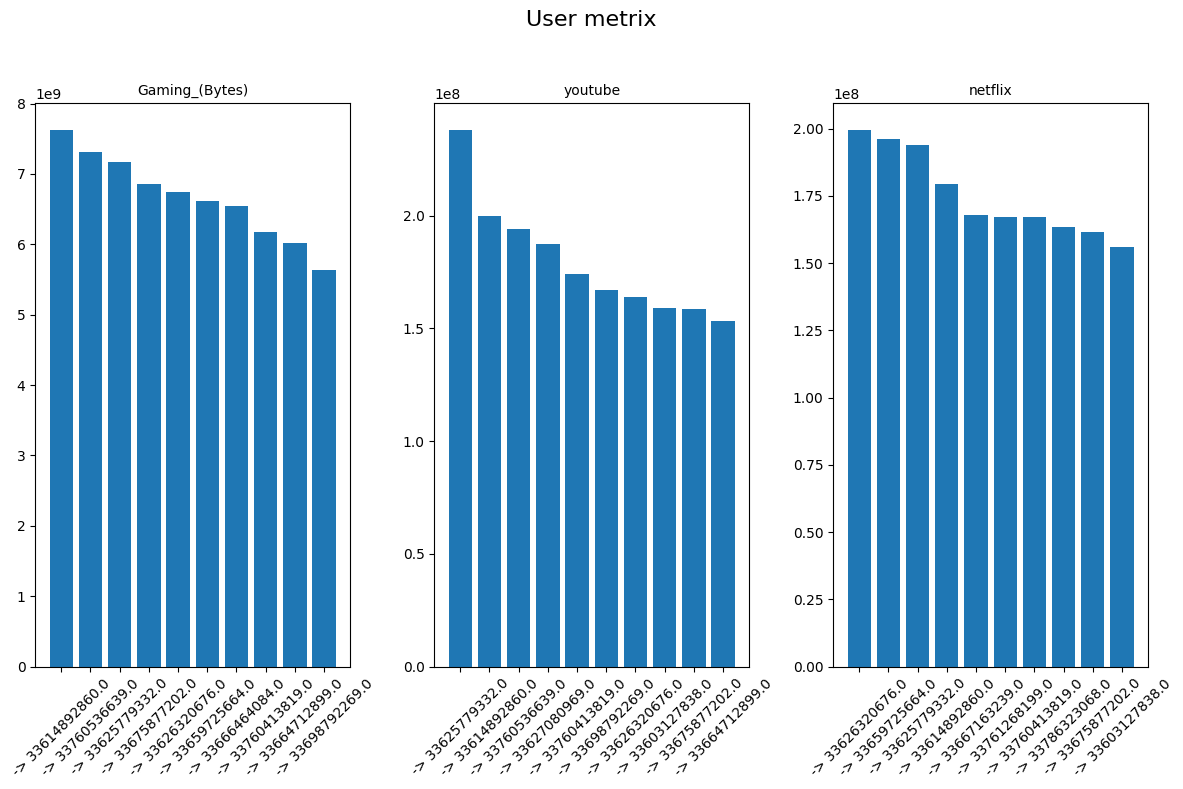

In [19]:
gaming = app_df.nlargest(10, "Gaming DL (Bytes)")['Gaming DL (Bytes)']
youtube = app_df.nlargest(10, "Youtube DL (Bytes)")['Youtube DL (Bytes)']
netflix = app_df.nlargest(10, "Netflix DL (Bytes)")['Netflix DL (Bytes)']
google = app_df.nlargest(10, "Google DL (Bytes)")['Google DL (Bytes)']
email = app_df.nlargest(10, "Email DL (Bytes)")['Email DL (Bytes)']
social_media = app_df.nlargest(10, "Social Media DL (Bytes)")['Social Media DL (Bytes)']
other = app_df.nlargest(10, "Other DL (Bytes)")['Other DL (Bytes)']


fn.mult_hist([gaming, youtube, netflix], 1,
          3, "User metrix", ["Gaming_(Bytes)", "youtube", "netflix"])

#plots.mult_hist([google, email, social_media, other], 1,
        #  4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

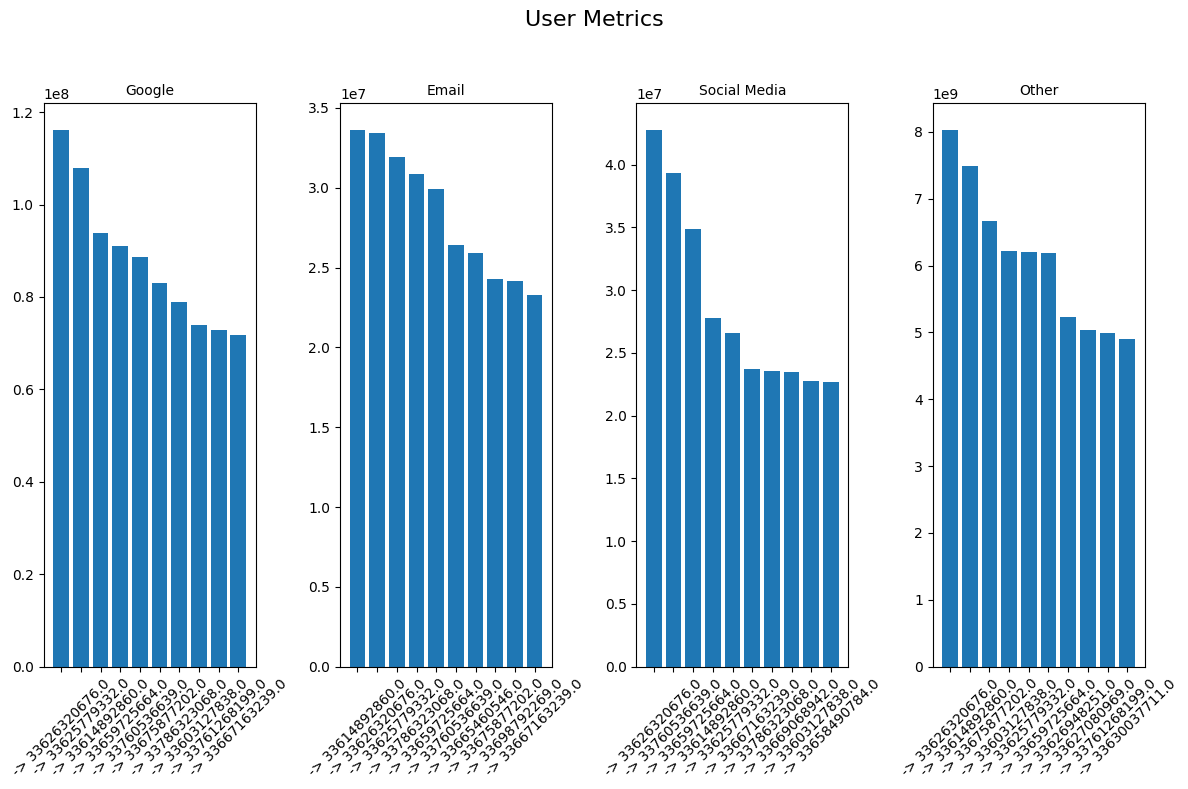

In [20]:
fn.mult_hist([google, email, social_media, other], 1,
         4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

In [21]:
top_3 = app_df.sum()
top_3

Gaming DL (Bytes)          6.267907e+13
Youtube DL (Bytes)         1.727699e+12
Netflix DL (Bytes)         1.726715e+12
Google DL (Bytes)          8.541724e+11
Email DL (Bytes)           2.660908e+11
Social Media DL (Bytes)    2.665897e+11
Other DL (Bytes)           6.254367e+13
dtype: float64

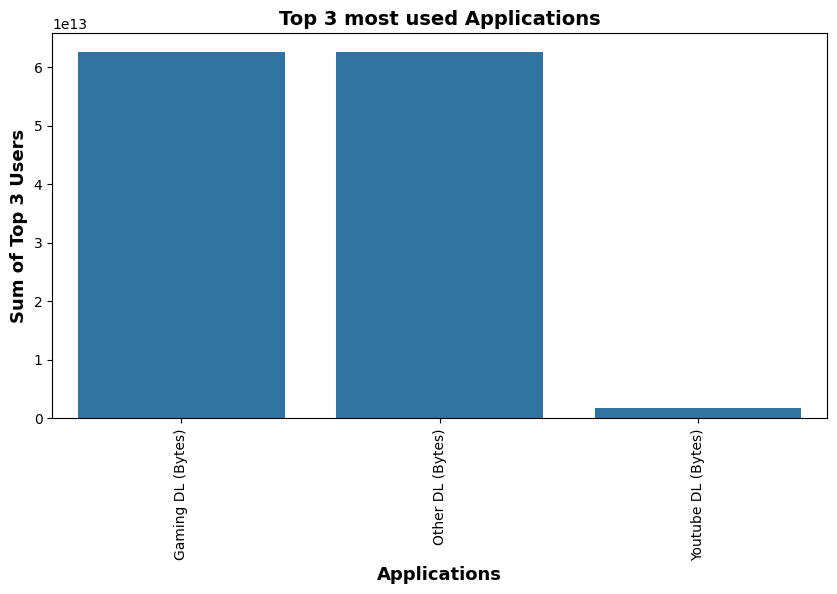

In [22]:
fn.plot_bar(top_3.nlargest(3), "Top 3 most used Applications", "Applications", "Sum of Top 3 Users")

In [23]:

from scipy.spatial.distance import cdist
def choose_kmeans(df: pd.DataFrame, num: int):
  distortions = []
  inertias = []
  K = range(1, num)
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    distortions.append(sum(
        np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeans.inertia_)


  return (distortions, inertias)

In [24]:
distortions, inertias = choose_kmeans(data_normalized, 15)

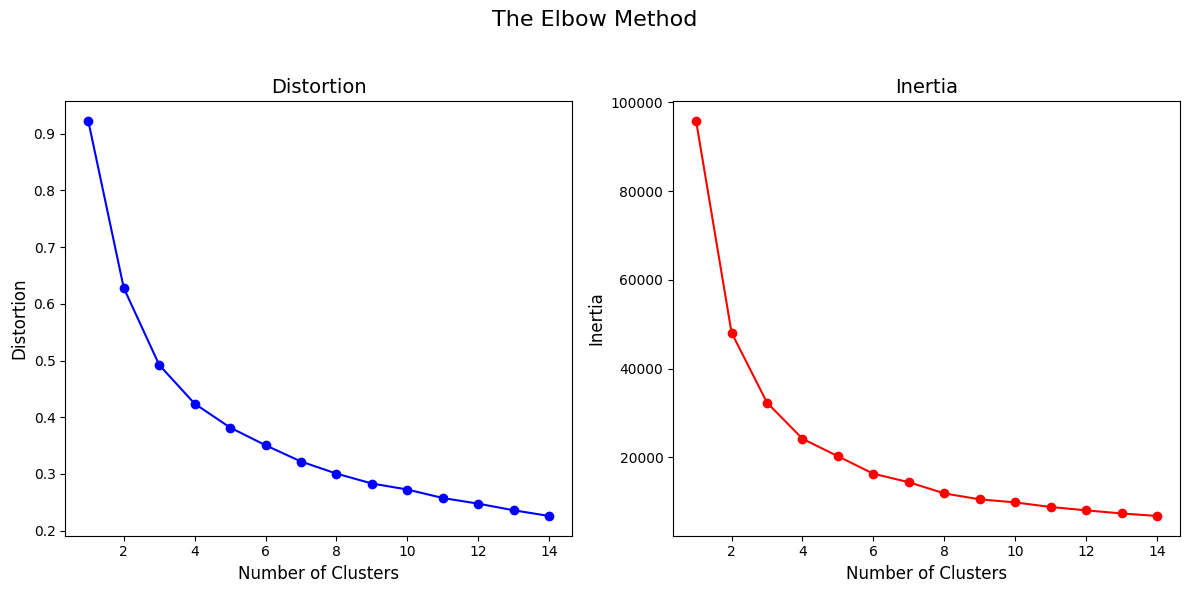

In [25]:
fn.plot_elbow_method(distortions, inertias)

Inferring from our plots, we can see that cluster value of 4 would be optimal since there is no significant decrease in inertia or distortion.

In [26]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_normalized)
user_engagement["Cluster"]= kmeans.labels_
user_engagement

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
3.360100e+10,1,1,116720.00,8.426375e+08
3.360100e+10,3,1,181230.00,1.207552e+08
3.360100e+10,2,1,134969.00,5.566597e+08
3.360101e+10,3,1,49878.00,4.019932e+08
3.360101e+10,0,2,37104.00,1.363130e+09
...,...,...,...,...
3.379000e+10,1,1,8810.00,6.879252e+08
3.379000e+10,3,1,140988.00,4.445751e+08
3.197021e+12,2,1,244958.75,1.948281e+08


In [27]:
# save the models
import pickle
with open("../models/User_engagement.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [28]:

#user_engagement.to_csv('../data/user_engagement.csv')